In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
import numpy as np
import cmocean
import warnings
warnings.filterwarnings("ignore")

In [2]:
# ##Unparameterized run
# %cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/default_noparameterization
# fs = xr.open_dataset('static.nc', decode_times=False)
# av=xr.open_dataset('averages_00031502.nc',decode_times=False)

# ##TRUTH CASE:
# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.0625deg_N15_baseline_hmix5
# fs = xr.open_dataset('static.nc', decode_times=False)
# av = xr.open_dataset('averages_00004502.nc', decode_times=False)
# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.03125deg_N15_baseline_hmix5
# fs = xr.open_dataset('static.nc', decode_times=False)
# os = xr.open_dataset('sub20/ocean.stats.nc', decode_times=False)
# av = xr.open_dataset('averages_00002702.nc', decode_times=False)
# %cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

# %cd /glade/scratch/eyankovsky/Backscatter_tests_with_Scott/Half_degree/05deg_KS02_COEF07/
# av = xr.open_dataset('averages_00031502.nc', decode_times=False)  
# fs = xr.open_dataset('static.nc', decode_times=False)

# %cd /glade/scratch/eyankovsky/Backscatter_tests_with_Scott/Half_degree/05deg_KS025_COEF1/
# av = xr.open_dataset('averages_00031502.nc', decode_times=False)  
# fs = xr.open_dataset('static.nc', decode_times=False)

#Contains default setup based on Jansen et al 2019. MEKE_VISCOSITY_COEFF_KU = -0.15; MEKE_KHCOEFF = 0.15
# %cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_GM_BS_default/
# av = xr.open_dataset('averages_00031502.nc', decode_times=False)  
# fs = xr.open_dataset('static.nc', decode_times=False)

# ## MEKE_VISCOSITY_COEFF_KU = -0.3; MEKE_KHCOEFF = 0.0
# %cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test16
# av = xr.open_dataset('averages_00031502.nc', decode_times=False)  
# fs = xr.open_dataset('static.nc', decode_times=False)

# ## MEKE_VISCOSITY_COEFF_KU = -0; MEKE_KHCOEFF = 0.5
# %cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test7
# av = xr.open_dataset('averages_00031502.nc', decode_times=False)  
# fs = xr.open_dataset('static.nc', decode_times=False)

%cd /glade/scratch/eyankovsky/Backscatter_tests_with_Scott/Half_degree/Jansen_KS025_CONST1
av = xr.open_dataset('averages_00031502.nc', decode_times=False)  
MEKEds = xr.open_dataset('MEKEaverages_00031502.nc', decode_times=False)

# %cd /glade/scratch/eyankovsky/Backscatter_tests_with_Scott/Half_degree/05deg_KS025_COEF1/
# av = xr.open_dataset('averages_00031502.nc', decode_times=False)
# MEKEds = xr.open_dataset('MEKEaverages_00031502.nc', decode_times=False)

fs = xr.open_dataset('static.nc', decode_times=False)

/glade/scratch/eyankovsky/Backscatter_tests_with_Scott/Half_degree/Jansen_KS025_CONST1


In [3]:
#Read in various grid variables from the static file:

depth = np.array(fs['depth_ocean'])
area_t=np.array(fs['area_t'])

xh = fs.xh.values
yh = fs.yh.values


KEterm1 = av['dKE_dt'][:,:,:,:].mean('time')
#assuming all of these are on the RHS of the KE equation
KEterm2 = av['KE_CorAdv'][:,:,:,:].mean('time')
#KEterm2_alternate = av['KE_adv'][:,:,:,:].mean('time')
KEterm3 = av['PE_to_KE'][:,:,:,:].mean('time')
KEterm4 = av['KE_BT'][:,:,:,:].mean('time')
KEterm5 = av['KE_visc'][:,:,:,:].mean('time')
KEterm6 = av['KE_horvisc'][:,:,:,:].mean('time')
#KE_stress = av['KE_stress'][:,:,:,:]#.mean('time') # Part of KEterm5, corresponds to surface wind stress contribution

#Summing vertically:
KEterm1 = (KEterm1).sum(axis=0);
KEterm2 = (KEterm2).sum(axis=0);
KEterm3 = (KEterm3).sum(axis=0);
KEterm4 = (KEterm4).sum(axis=0);
KEterm5 = (KEterm5).sum(axis=0);
KEterm6 = (KEterm6).sum(axis=0);
#KE_stress = KE_stress.sum(axis=0)

# #Or picking one layer:
# k=3
# KEterm1 = (KEterm1)[0,k,:,:]#.sum(axis=0);
# KEterm2 = (KEterm2)[0,k,:,:]#.sum(axis=0);
# KEterm3 = (KEterm3)[0,k,:,:]#.sum(axis=0);
# KEterm4 = (KEterm4)[0,k,:,:]#.sum(axis=0);
# KEterm5 = (KEterm5)[0,k,:,:]#.sum(axis=0);
# KEterm6 = (KEterm6)[0,k,:,:]#.sum(axis=0);

E = KEterm1-KEterm2-KEterm3-KEterm4-KEterm5-KEterm6 #residual term between dKE/dt and RHS of equation
#E_alternate = KEterm1-KEterm2_alternate-KEterm3-KEterm4-KEterm5-KEterm6

In [4]:
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [5]:
KEterm1.shape

(280, 120)

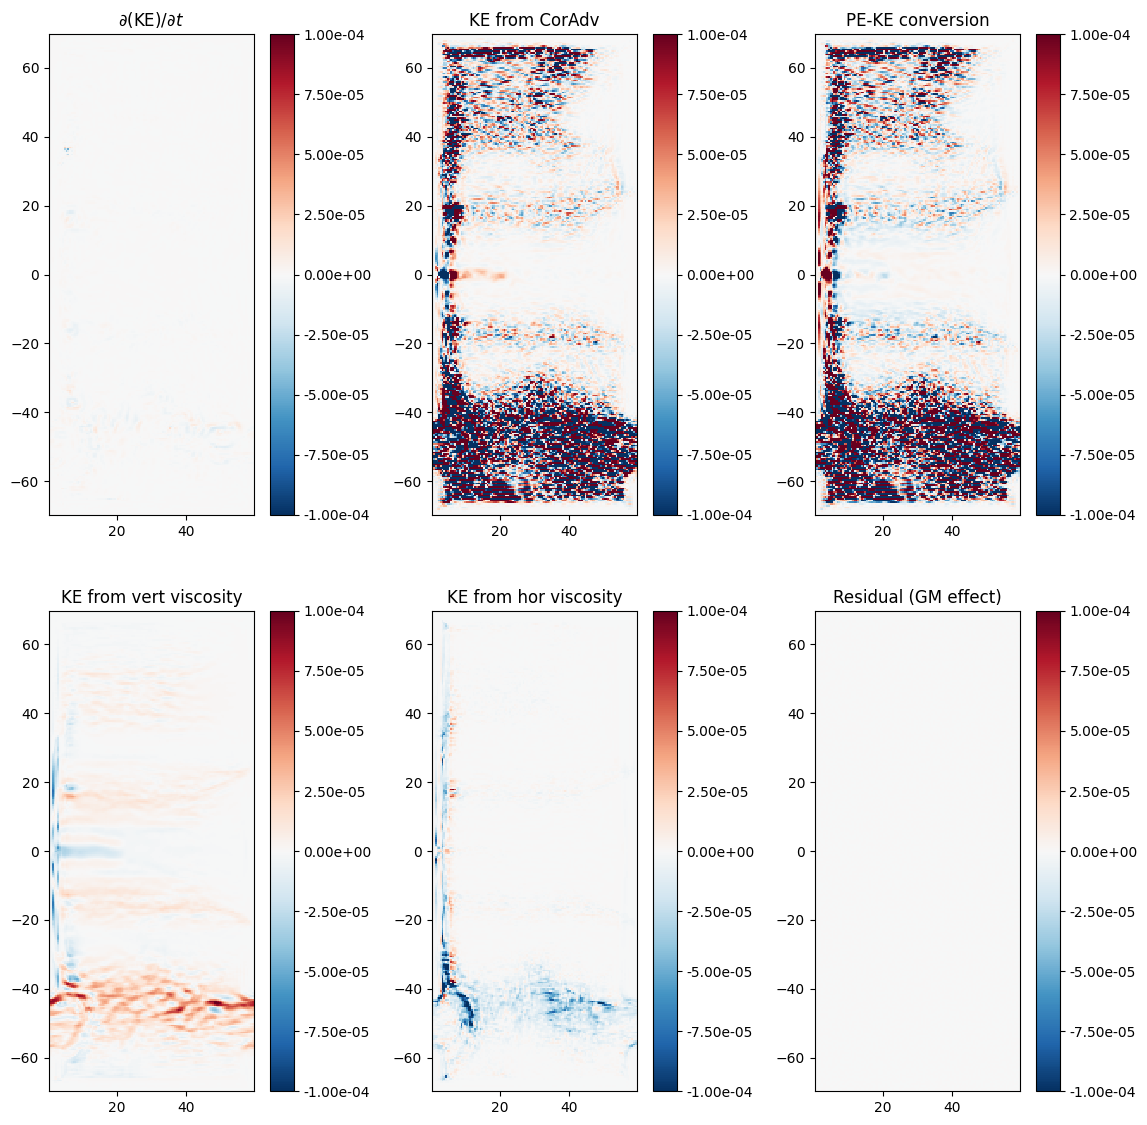

In [6]:
plt.figure(figsize=(14,14),dpi=100)


cmin=-1e-4; cmax=1e-4;
plt.subplot(2,3,1)
plt.pcolormesh(xh,yh,KEterm1,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\partial ($KE$)/\partial t$')
cbar=plt.colorbar(format='%.2e')

plt.subplot(2,3,2)
plt.pcolormesh(xh,yh,KEterm2,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'KE from CorAdv')
cbar=plt.colorbar(format='%.2e')
plt.subplot(2,3,3)
plt.pcolormesh(xh,yh,(KEterm3+KEterm4),norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'PE-KE conversion')
cbar=plt.colorbar(format='%.2e')


plt.subplot(2,3,4)
plt.pcolormesh(xh,yh,KEterm5,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'KE from vert viscosity')
cbar=plt.colorbar(format='%.2e')

plt.subplot(2,3,5)
plt.pcolormesh(xh,yh,KEterm6,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'KE from hor viscosity')
cbar=plt.colorbar(format='%.2e')

plt.subplot(2,3,6)
plt.pcolormesh(xh,yh,E,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'Residual (GM effect)')
cbar=plt.colorbar(format='%.2e')


In [7]:
MEKE = MEKEds.MEKE.mean('time')
MEKE_KU = MEKEds.MEKE_KU.mean('time')
MEKE_Ub = MEKEds.MEKE_Ub.mean('time')

In [8]:
MEKE_Ub.shape

(280, 120)

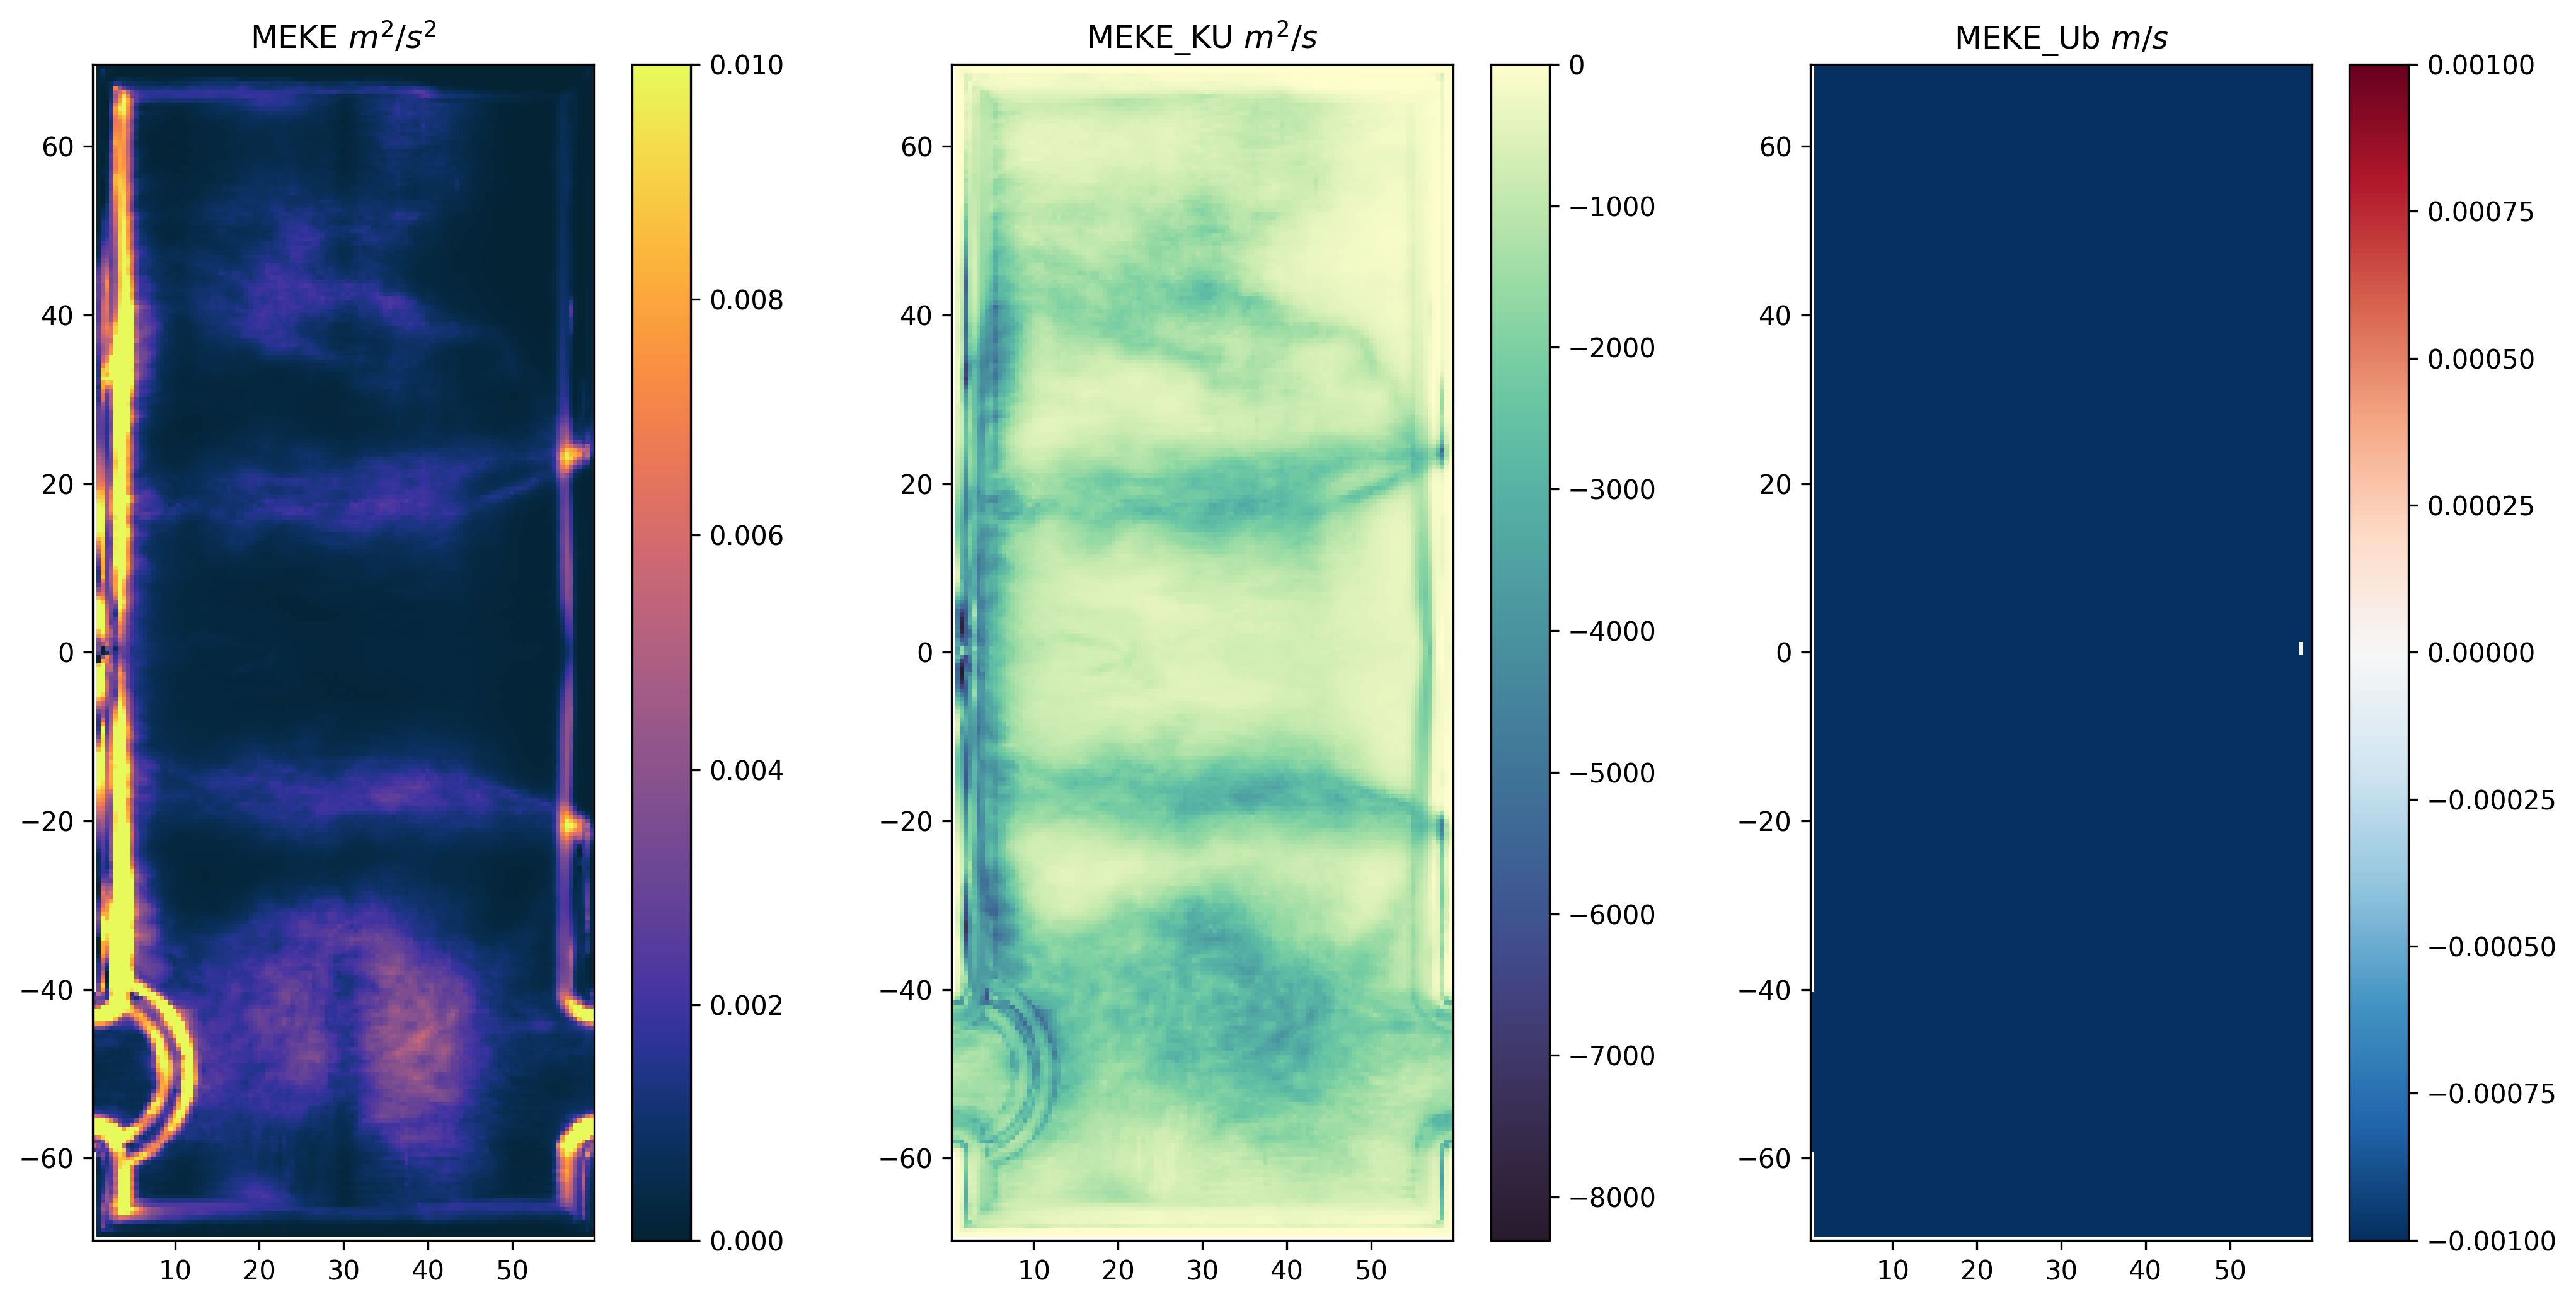

In [9]:
plt.figure(figsize=(14,7),dpi=300)


cmin=-1e-4; cmax=1e-4;
plt.subplot(1,3,1)
plt.pcolormesh(xh,yh,MEKE,cmap=cmocean.cm.thermal,vmin=0.,vmax=.01)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'MEKE $m^2/s^2$')
plt.colorbar()


plt.subplot(1,3,2)
plt.pcolormesh(xh,yh,MEKE_KU,cmap=cmocean.cm.deep_r)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'MEKE_KU $m^2/s$')
plt.colorbar()

plt.subplot(1,3,3)
plt.pcolormesh(xh,yh,MEKE_KU,cmap=plt.cm.RdBu_r,vmin=-1.e-3,vmax=1e-3)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'MEKE_Ub $m/s$')
plt.colorbar()

plt.tight_layout()


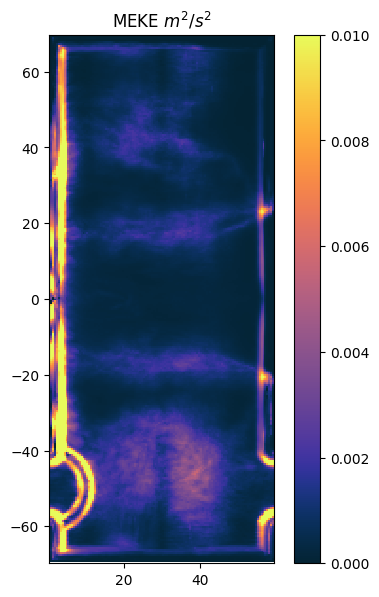

In [10]:
plt.figure(figsize=(5,7),dpi=100)


cmin=-1e-4; cmax=1e-4;

plt.pcolormesh(xh,yh,MEKE,cmap=cmocean.cm.thermal,vmin=0.,vmax=.01)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'MEKE $m^2/s^2$')
plt.colorbar()
